In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [6]:
# from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, Convolution2D
from keras.layers import AveragePooling2D, Input, Flatten, MaxPool2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


batch_size = 64
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    return round(0.004 * 1/(1 + 0.319 * epoch), 10)

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 maxpool=False):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Convolution2D(num_filters,
                  kernel_size=(kernel_size, kernel_size),
                  strides=strides,
                  padding='same',
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(1e-4),
                   use_bias=False
                   )

    x = inputs
    if conv_first:
        x = conv(x)
        if maxpool:
            x = MaxPooling2D((2,2))(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            # x = Dropout(0.03)(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            maxpool = False
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
                maxpool = True
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                            #  strides=strides,
                             maxpool=maxpool)
            # y = Dropout(0.1)(y)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                #  strides=strides,
                                 maxpool=maxpool,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            # x = keras.layers.concatenate([x,y],axis=-1)
            # x = Activation('relu')(x)
            # x = Dropout(0.1)(x)
            # x = resnet_layer(inputs=x,
            #                  num_filters=num_filters,
            #                  kernel_size=1,
            #                  )
            # x = Dropout(0.1)(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    # y = resnet_layer(inputs=x,
    #                              num_filters=10,
    #                              kernel_size=1,
    #                              strides=1,
    #                              activation='softmax',
    #                              batch_normalization=False)
    # outputs = Flatten()(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    )(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [13]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              # optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule,verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 16)   64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 16)   0           batch_normalization_2[0][0]      
________________________________________________________________________________________

In [14]:
# Run training, with or without data augmentation.
epochs = 50
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=get_random_eraser(v_l=0,v_h=1),
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1,
                        callbacks=callbacks)

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.004.
782/782 [==============================] - 67s 86ms/step - loss: 1.5813 - acc: 0.4590 - val_loss: 2.9541 - val_acc: 0.3369

Epoch 00001: val_acc improved from -inf to 0.33690, saving model to /content/saved_models/cifar10_ResNet20v1_model.001.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0030326005.
782/782 [==============================] - 58s 75ms/step - loss: 1.2103 - acc: 0.6214 - val_loss: 1.3872 - val_acc: 0.5882

Epoch 00002: val_acc improved from 0.33690 to 0.58820, saving model to /content/saved_models/cifar10_ResNet20v1_model.002.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0024420024.
782/782 [==============================] - 58s 74ms/step - loss: 1.0602 - acc: 0.6802 - val_loss: 1.3916 - val_acc: 0.5873


In [15]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 339us/step
Test loss: 0.4609039987564087
Test accuracy: 0.8893


## Visualize

In [0]:
from keras.preprocessing import image
import numpy as np
import cv2
from keras import backend as K
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def showGrad(files):
    n = len(files)
    fig, axes = plt.subplots(n, 2,figsize=(32,20))
    
    
    for file_index,url in enumerate(files):
        dog = io.imread(url)
        dog = cv2.resize(dog, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        x = image.img_to_array(dog/255)
        x = np.expand_dims(x, axis=0)
        if subtract_pixel_mean:
            x -= x_train_mean

        preds = model.predict(x)
        class_idx = np.argmax(preds[0])
        class_output = model.output[:, class_idx]
        last_conv_layer = model.get_layer("conv2d_22")

        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([x])
        for i in range(64):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
        heatmap = np.mean(conv_layer_output_value, axis = -1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
        superimposed_img = cv2.resize(superimposed_img, (dog.shape[1]*4, dog.shape[0]*4), interpolation=cv2.INTER_CUBIC)
        dog = cv2.resize(dog, (dog.shape[1]*4, dog.shape[0]*4), interpolation=cv2.INTER_CUBIC)
        axes[file_index,0].imshow(dog)
        axes[file_index,1].imshow(superimposed_img)
    plt.savefig('gradcam.png')
    plt.show()

In [0]:
urls = [
        'https://cdn-image.travelandleisure.com/sites/default/files/styles/1600x1000/public/1562859315/air-france-airplane-AIRFRANCECO0719.jpg?itok=blKsWDFm',
        'https://cnet3.cbsistatic.com/img/2_XVRUidMnV14mgVIOpbLFw8XpY=/fit-in/x/2017/11/08/4f6f21fd-0f5e-431d-bcad-329aca80c6a6/snapseed6.jpg',
        'https://fthmb.tqn.com/p4duqUvzu185Vcu-MxxjrSa8ST0=/1500x1000/filters:fill(auto,1)/red-summer-tanager-58991d123df78caebc049ac4.jpg',
        'https://www.naturalcatcareblog.com/wp-content/uploads/2011/09/two_cats.jpg',
        'https://www.animalspot.net/wp-content/uploads/2019/03/Roe-Deer-Image.jpg',
        'https://r.hswstatic.com/w_907/gif/smilingdog-1.jpg',
        'https://i1.wp.com/www.cleverchameleon.com.au/wp-content/uploads/2017/09/david-clode-341216.jpg?resize=525%2C337&ssl=1',
        'https://www.horsebreedsinfo.com/images/Alter-Real.jpg',
        # 'http://passengersinhistory.sa.gov.au/sites/default/files/imported/1516_0.jpg',
        'https://cdn.oemoffhighway.com/files/base/acbm/ooh/image/2016/07/960w/Volvo_TruckPlatoon3.578cc9ee5c7e9.jpg',
]

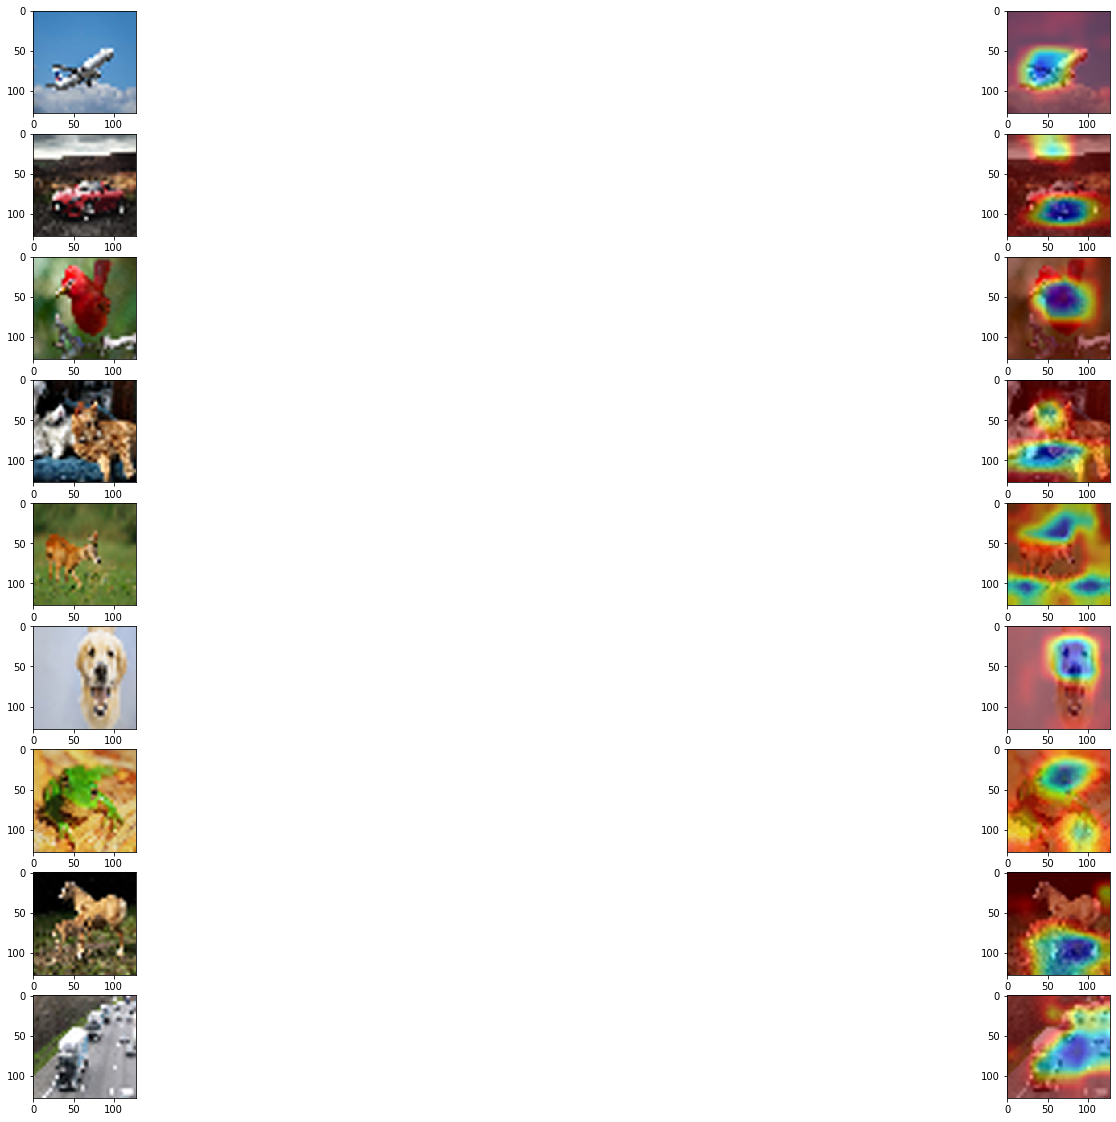

In [22]:
showGrad(urls)